-----------------     ASSIGNMENT #3  -----     Group Members -> Saad Hassan(21L-5252)  -> Waleed Malik(21L-5248)

TASK 1 - POINTS ON THE CANVAS

In [4]:
import tkinter as tk
import numpy as np
import math

def placeDot(event, canvas, points):
    x, y = event.x, event.y
    points.append((x, y))
    canvas.create_oval(x-3, y-3, x+3, y+3, fill='blue')

def applyHoughOnDots(canvas, points):
    if len(points) < 2:
        print("Place at least 2 dots to detect lines.")
        return

    # Create accumulator for Hough Transform
    width, height = 500, 500
    maxDist = int(math.hypot(width, height))
    accumulator = np.zeros((180, 2 * maxDist))

    # Populate the accumulator
    for x, y in points:
        for theta in range(180):
            thetaRad = math.radians(theta)
            rho = int(x * math.cos(thetaRad) + y * math.sin(thetaRad))
            accumulator[theta, rho + maxDist] += 1

    threshold = 2
    lines = [(theta, rho - maxDist) for theta in range(180) for rho in range(2 * maxDist)
             if accumulator[theta, rho] >= threshold]

    drawLines(canvas, lines)

def drawLines(canvas, lines):
    for theta, rho in lines:
        thetaRad = math.radians(theta)
        a = math.cos(thetaRad)
        b = math.sin(thetaRad)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        canvas.create_line(x1, y1, x2, y2, fill='red')

def main():
    root = tk.Tk()
    root.title("Hough Transform on Placed Dots")

    # Canvas setup
    canvas = tk.Canvas(root, width=500, height=500, bg='white')
    canvas.pack()
    points = []
    canvas.bind("<Button-1>", lambda event: placeDot(event, canvas, points))
    
    tk.Button(root, text="Apply Hough Transform on Dots", 
              command=lambda: applyHoughOnDots(canvas, points)).pack()
    root.mainloop()

if __name__ == "__main__":
    main()


TASK 2 - LINES FROM IMAGES

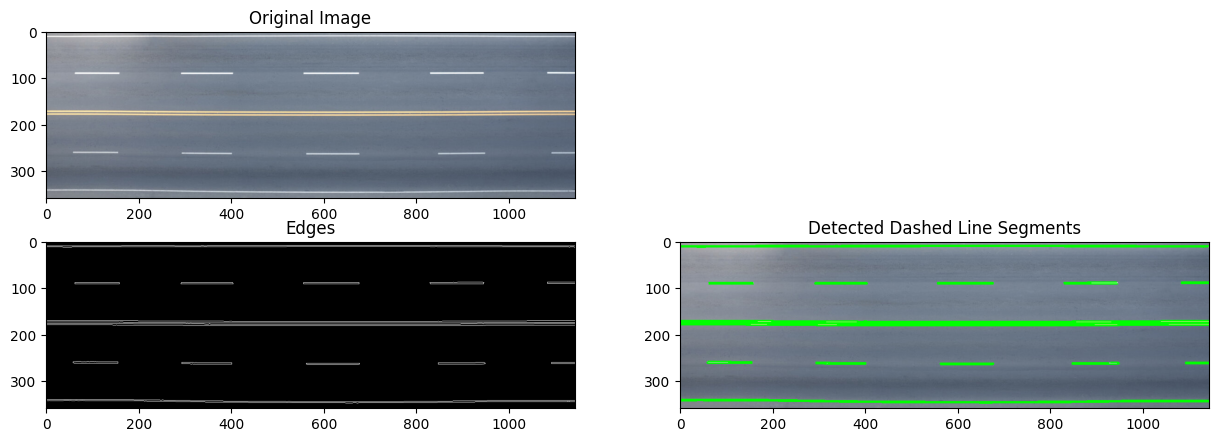

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def customHoughTransform(edges, thetaResolution, voteThreshold, minSegmentLength, maxSegmentGap):
    imgHeight, imgWidth = edges.shape
    maxDistance = int(np.hypot(imgHeight, imgWidth))  
    houghAccumulator = np.zeros((2 * maxDistance, int(np.pi / thetaResolution)))  
    thetaValues = np.linspace(-np.pi / 2, np.pi / 2, houghAccumulator.shape[1])

    # Populate Hough accumulator with votes
    edgePixels = np.argwhere(edges)  
    for y, x in edgePixels:
        for thetaIndex, theta in enumerate(thetaValues):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            houghAccumulator[rho + maxDistance, thetaIndex] += 1

    detectedLines = []
    for rhoIndex, thetaIndex in np.argwhere(houghAccumulator > voteThreshold):
        rho = rhoIndex - maxDistance
        theta = thetaValues[thetaIndex]
        detectedLines.append((rho, theta))

    lineSegments = []
    for rho, theta in detectedLines:
        segmentPoints = []
        
        for y, x in edgePixels:
            if abs(int(x * np.cos(theta) + y * np.sin(theta)) - rho) < maxSegmentGap:
                if not segmentPoints or np.hypot(x - segmentPoints[-1][0], y - segmentPoints[-1][1]) < maxSegmentGap:
                    segmentPoints.append((x, y))
                else:
                    if len(segmentPoints) >= minSegmentLength:
                        lineSegments.append(segmentPoints)
                    segmentPoints = [(x, y)]
        
        if len(segmentPoints) >= minSegmentLength:
            lineSegments.append(segmentPoints)

    return lineSegments

def drawSegments(inputImage, lineSegments):
    resultImage = inputImage.copy()
    for segment in lineSegments:
        for i in range(0, len(segment) - 1, 2): 
            pt1 = segment[i]
            pt2 = segment[i + 1] if i + 1 < len(segment) else pt1
            cv2.line(resultImage, pt1, pt2, (0, 255, 0), 2)
    return resultImage

def main():
    imagePath = 'D:/Wallapaper/4.jpg'
    originalImage = cv2.imread(imagePath)

    grayscaleImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)

    cannyThreshold1 = 50
    cannyThreshold2 = 150
    thetaResolution = np.pi / 180
    voteThreshold = 50
    minSegmentLength = 20
    maxSegmentGap = 10
    edgeImage = cv2.Canny(grayscaleImage, cannyThreshold1, cannyThreshold2)
    
    # Custom Hough Transform parameters

    
    # Apply custom Hough Transform to detect dashed lines
    dashedSegments = customHoughTransform(
        edgeImage,  
        thetaResolution=thetaResolution, 
        voteThreshold=voteThreshold, 
        minSegmentLength=minSegmentLength, 
        maxSegmentGap=maxSegmentGap
    )

    # Draw the detected segments as dashed lines
    resultImage = drawSegments(originalImage, dashedSegments)
    
    # Display the results
    plt.figure(figsize=(15, 10))
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    
    plt.subplot(121)
    plt.imshow(edgeImage, cmap='gray')
    plt.title('Edges')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(resultImage, cv2.COLOR_BGR2RGB))
    plt.title('Detected Dashed Line Segments')
    plt.show()

if __name__ == "__main__":
    main()
